# Process

# Dependency Parsing

In [1]:
import spacy
from spacy import displacy
text='she books me the morning flight'
# text= 'book the flight through houston' #arc-eager
# text = 'I am hungry' #arc-standard
# text = 'Viken will join the board as a nonexecutive director Nov 29'
def convertToSpacy(text):
    nlp=spacy.load('en_core_web_sm/en_core_web_sm-3.4.1/')
    word_list = list()
    print ("{:<5} | {:<10} | {:<8} | {:<10} | {:<20}".format('Index','Token','Relation','Head', 'Children'))
    print ("-" * 70)
    for index,token in enumerate(nlp(text)):
        # print(index+1, token.text,'=>',token.dep_,'=>',token.head.text)
        print ("{:<5} | {:<10} | {:<8} | {:<10} | {:<20}"
         .format(str(index+1),str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))
        # text = np.array([index+1,token.text,token.dep_])
        # np.append(list_text,text)
        word_list.append((index+1,token.text,token.head.text,token.dep_)) #token.dep_ 
        # dep_list.append((token.text,token.dep_,token.head.text))
    displacy.render(nlp(text),jupyter=True)
      
    return word_list

In [2]:
text = 'she books me the morning flight'
word_list = convertToSpacy(text)
word_list

Index | Token      | Relation | Head       | Children            
----------------------------------------------------------------------
1     | she        | nsubj    | books      | []                  
2     | books      | ROOT     | books      | [she, me, flight]   
3     | me         | dative   | books      | []                  
4     | the        | det      | flight     | []                  
5     | morning    | compound | flight     | []                  
6     | flight     | dobj     | books      | [the, morning]      


[(1, 'she', 'books', 'nsubj'),
 (2, 'books', 'books', 'ROOT'),
 (3, 'me', 'books', 'dative'),
 (4, 'the', 'flight', 'det'),
 (5, 'morning', 'flight', 'compound'),
 (6, 'flight', 'books', 'dobj')]

# 1. Greedy Transition-Based Dependency Parsing

## 1.1.1 Stack : Enqueue and Dequeue (Non-related Dependency Parsing)

In [3]:
from collections import deque
class Stack(object):
    def __init__(self):
        self.container = deque()
    def push(self,*value):
        self.container.append(*value)
    def pop(self):
        if len(self.container) != 0:
            return self.container.pop()  
        else: raise IndexError("An empty deque")
    def size(self):
        return len(self.container)

In [4]:
s = Stack()
#push items
for i in range(len(word_list)):
    s.push(word_list[i][1])
    
print("Initial queue")
print(s.container)

#pop items
for i in range(len(word_list)):
    s.pop()
    
print("\nQueue after removing elements")
print(s.container)
#Finish Stack is easy!!!

Initial queue
deque(['she', 'books', 'me', 'the', 'morning', 'flight'])

Queue after removing elements
deque([])


## 1.1.2. Stack and Buffer

- LEFTARC: Assert a head-dependent relation between the word at the top of the stack and the word directly beneath it; 
remove the lower word from the stack. 
- RIGHTARC: Assert a head-dependent relation between the second word on the stack and the word at the top; 
remove the word at the top of the stack; 
- SHIFT: Remove the word from the front of the input buffer and push it onto the stack.

Start with root on stack, buffer with whole sentence
- If there’s nothing on the stack, you must shift
- If the top of the stack is the child of the top of the buffer, then make a left
edge
- If the top of the buffer is is a child of the top of the stack and the top of
the buffer has no children that have yet to be added to the tree, then
make a right



In [5]:
class Configuration(object):
    def __init__(self,dependency_list):
        self.stack = [(0,'root','root','ROOT')]
        self.buffer = dependency_list
        self.arcs = list()
    def __str__(self):
        return f'Stack  : {self.stack} \nBuffer : {self.buffer} \nArcs   : {self.arcs}'

class Transition(object): ####put word to buffer####
    def __init__(self,approach):
        self.approach = approach #'arc-standard' or 'arc-eager'
    #Arc-standard parsing cannot produce non-projective trees
    def left_arc(self,config,relation):
        if self.approach == 'arc-standard':
            #pop top of stack -> append arc relation
            index_i = config.stack.pop()
            index_j = config.stack.pop()
            config.stack.append(index_i)
            config.arcs.append((index_i, relation, index_j)) 
        elif self.approach == 'arc-eager':
            pass

    def right_arc(self,config,relation):
        if self.approach == 'arc-standard':
            #pop top of stack -> append arc relation
            index_i = config.stack.pop()
            index_j = config.stack.pop()
            config.stack.append(index_j)
            config.arcs.append((index_j, relation, index_i)) 
        elif self.approach == 'arc-eager':
            pass

    def shift(self,config): #move buffer to stack
        if len(config.buffer) <= 0:
            return -1
        index_i = config.buffer.pop(0)
        config.stack.append(index_i)

    def reduce(sefl,config): #'arc-eager'
        pass

class Parser(object): 
    def __init__(self,approach):
        self.approach = approach

    def oracle(self,config): ####put buffer to stack####
        operation = Transition(self.approach)
        i = 0
        print('\nAction :',end=' ')
        while not(len(config.buffer) == 0 and len(config.stack) == 1): #stop when buffer is empty and stack contain only root
            if (len(config.buffer) == 0 and len(config.stack) == 2):
                print('Right-Arc',end='->')
                operation.right_arc(config,'->')
                
            if len(config.stack) == 1:
                print("Shift_along",end='->')
                operation.shift(config)
            else:
                if config.stack[-1][1] == config.stack[-2][2]: 
                    print('Left-Arc',end='->')
                    operation.left_arc(config,'->')
                elif (config.stack[-1][2] == config.stack[-2][1]) : #next_head = prev_text
                    print('Right-Arc',end='->')
                    operation.right_arc(config,'->')
                else:
                    print("Shift",end='->')
                    operation.shift(config)
            i+=1
            if i == 20:
                break
        # print('\n',config)
        print('\n') 
        return config

def SaB(word_list):
    print('Setup Configuration')
    buffer_list = word_list.copy()
    config = Configuration(buffer_list)
    print(config)
    print('Trainsition-Based')
    parsing = Parser('arc-standard')
    new_config = parsing.oracle(config)
    print(new_config)
    return new_config
    #index, token, head, relation

In [6]:
new_config = SaB(word_list)

Setup Configuration
Stack  : [(0, 'root', 'root', 'ROOT')] 
Buffer : [(1, 'she', 'books', 'nsubj'), (2, 'books', 'books', 'ROOT'), (3, 'me', 'books', 'dative'), (4, 'the', 'flight', 'det'), (5, 'morning', 'flight', 'compound'), (6, 'flight', 'books', 'dobj')] 
Arcs   : []
Trainsition-Based

Action : Shift_along->Shift->Left-Arc->Shift->Right-Arc->Shift->Shift->Shift->Left-Arc->Left-Arc->Right-Arc->Right-Arc->Shift_along->

Stack  : [(0, 'root', 'root', 'ROOT')] 
Buffer : [] 
Arcs   : [((2, 'books', 'books', 'ROOT'), '->', (1, 'she', 'books', 'nsubj')), ((2, 'books', 'books', 'ROOT'), '->', (3, 'me', 'books', 'dative')), ((6, 'flight', 'books', 'dobj'), '->', (5, 'morning', 'flight', 'compound')), ((6, 'flight', 'books', 'dobj'), '->', (4, 'the', 'flight', 'det')), ((2, 'books', 'books', 'ROOT'), '->', (6, 'flight', 'books', 'dobj')), ((0, 'root', 'root', 'ROOT'), '->', (2, 'books', 'books', 'ROOT'))]


## 1.2. Dependency Tree
- The dependency structure is a tree (directed acyclic graph) with the main verb as its root (head). (Projective)

In [7]:
new_config.arcs #book go to she

[((2, 'books', 'books', 'ROOT'), '->', (1, 'she', 'books', 'nsubj')),
 ((2, 'books', 'books', 'ROOT'), '->', (3, 'me', 'books', 'dative')),
 ((6, 'flight', 'books', 'dobj'), '->', (5, 'morning', 'flight', 'compound')),
 ((6, 'flight', 'books', 'dobj'), '->', (4, 'the', 'flight', 'det')),
 ((2, 'books', 'books', 'ROOT'), '->', (6, 'flight', 'books', 'dobj')),
 ((0, 'root', 'root', 'ROOT'), '->', (2, 'books', 'books', 'ROOT'))]

In [8]:
def DependencyGraph(word_list,new_config):
    from collections import defaultdict
    graph_default = defaultdict(list)
    for i in range(len(word_list)+1):
        # for j in range(len(word_list)+1):
        # graph_default.setdefault(i)
        graph_default[f'{i}'] = []
    for i in new_config.arcs:
    #     graph_default[i[0][0]][i[2][0]] = ((i[2][0],i[2][0]))
        graph_default[f"{i[0][0]}"].append(f'{i[2][0]}')
    return graph_default

In [9]:
DGraph = DependencyGraph(word_list,new_config)
DGraph

defaultdict(list,
            {'0': ['2'],
             '1': [],
             '2': ['1', '3', '6'],
             '3': [],
             '4': [],
             '5': [],
             '6': ['5', '4']})

### 1.2.1 Breadth-first Search

In [10]:
def BFS(graph,s):
    visited = set() #unique number
    queue = set()   #list in python is basiaclly queue
    visited.add(s)  #means make it black
    queue.add(s)

    while queue:        #as long as the queue is not empty....
        u = queue.pop() #pop the front guy.... basiaclly index 0
        
        print(u, "-->", end = " ") 
        for neighbor in graph[u]:       #for everyone who connects to u,
            if neighbor not in visited:
                visited.add(neighbor)    #add them to visited
                queue.add(neighbor)      #add them to the queue

BFS(DGraph,'0')

0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 

### 1.2.2 Depth-first Search

In [11]:
visited = set()
def DFS(graph,s):
    if s not in visited:
        print(s,'-->',end=" ")
        visited.add(s)
        for neighbor in graph[s]:
            DFS(graph,neighbor)

DFS(DGraph,'0')

0 --> 2 --> 1 --> 3 --> 6 --> 5 --> 4 --> 

### 1.2.3 Beam Search 

### Reference : Transition-Based
- https://www.youtube.com/watch?v=xG0MXIPVUdk&list=PLyyEwPZh6aHpDieqWwr7hTgreKnYSY9Ox&index=60
- https://www.youtube.com/watch?v=2jLk93iIyrw&list=PLr9TFf9GjancAHiiP5cqGmYsZad99Uf_h&index=39
- https://www.youtube.com/watch?v=f5-hTA9hA3s&list=WL&index=8
- https://www.youtube.com/watch?v=oLHnqGmQtI4
- http://www.cs.umd.edu/class/fall2017/cmsc723/slides/slides_13.pdf
- Chapter 15 Dependency Parsing, Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright c 2019. All rights reserved. Draft of October 2, 2019.
- Covington, M. (2001). A fundamental algorithm for dependency parsing. In Proceedings of the 39th Annual ACM Southeast Conference, 95–102.
- Nivre, J. (2003). An efficient algorithm for projective dependency parsing. In Proceedings of the 8th International Workshop on Parsing Technologies (IWPT).

# 2. Graph-Based Dependency Parsing (Non-projective)

## 2.1 Maximum Spanning Tree (Chu-Liu-Edmonds)

## Comparision

0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 0 --> 2 --> 1 --> 6 --> 3 --> 4 --> 5 --> 

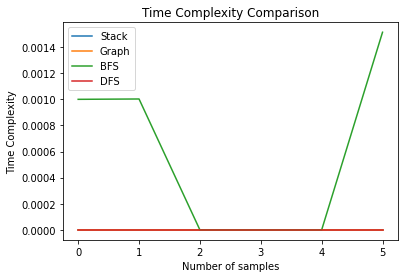

In [12]:
def comparision(word_list,new_config,DGraph,s):
    import time
    import matplotlib.pyplot as plt
    time_interval_Stack = []
    time_interval_Graph = []
    time_interval_BFS = []
    time_interval_DFS = []
    num_samples = [i for i in range(len(word_list))]
    for n in num_samples:
        start_time = time.time()
        s.push(n)
        elapsed_time = time.time() - start_time
        time_interval_Stack.append(elapsed_time)

        start_time = time.time()
        DependencyGraph(word_list,new_config)
        elapsed_time = time.time() - start_time
        time_interval_Graph.append(elapsed_time)

        start_time = time.time()
        BFS(DGraph,str(0))
        elapsed_time = time.time() - start_time
        time_interval_BFS.append(elapsed_time)

        start_time = time.time()
        DFS(DGraph,str(0))
        elapsed_time = time.time() - start_time
        time_interval_DFS.append(elapsed_time)

    plt.plot(num_samples,time_interval_Stack,label='Stack')
    plt.plot(num_samples,time_interval_Graph,label='Graph')
    plt.plot(num_samples,time_interval_BFS,label='BFS')
    plt.plot(num_samples,time_interval_DFS,label='DFS')
    plt.legend()
    plt.xlabel("Number of samples")
    plt.ylabel("Time Complexity")
    plt.title("Time Complexity Comparison")
    plt.show()

comparision(word_list,new_config,DGraph,s)

In [13]:
#Stack O(1)
#Graph O(1)
#BFS O(V + E)	
#DFS O(V + E)

### Reference 
- https://courses.cs.washington.edu/courses/cse490u/17wi/slides/CLE.pdf
- https://www.youtube.com/watch?v=dOCRzahEL84

# Future Work
- Implementation Non-projective
- Implementation Oracle using Machine Learning Model
- Implementatio arc-eager